This script shows a simple example of how to run the auditory model emulators on a music example not seen during training.

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from waveEar import *

In [15]:
## Choose auditory model - Verhulst will be added upon request
aud_model  = 'Zilany'

#Hearing losses available in this example: N0 and N3
HL = 'N3'
#Number of auditory model channels were downsampled to compress the data size, from 32 to 16 channels, corresponding to a factor 2.
ds = 2
#Scaling factor
scalar = 1
# Choose device: cpu or cuda
device = 'cpu'
#Silence before music starts
silence = 10000
#Using a slightly longer context window 
context = 1024

In [17]:
##Load data and modles
AME_MAE = torch.load('./models/' + aud_model + '_' + HL + '_MAE.p')
MAE_model = AME_MAE[0].to(device)
AME_FMAE = torch.load('./models/' + aud_model + '_' + HL + '_FMAE.p')
FMAE_model = AME_FMAE[0].to(device)
FMAE_weights = AME_FMAE[1].to(device)
## Data -  input in [0] and output in [1]
data = torch.load('./data/' + HL + '_60.pt')
#% Use roughly 1.5 seconds of the total 30 seconds file
in_ref = torch.tensor(data[0]).float().to(device)[:,:,silence:silence+1024*30]
out_ref = data[1][:,context+silence:1024*30+silence-context] * scalar

C:\Users\PELB\AppData\Local\Temp\ipykernel_22764\2103390117.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_ref = torch.tensor(data[0]).float().to(device)[:,:,silence:silence+1024*30]


In [18]:
#Run models
out_MAE = MAE_model(in_ref)[0,::ds,context:-context].detach().cpu().numpy() 
out_FMAE = (FMAE_model(in_ref) / FMAE_weights[None,:,None])[0,::ds,context:-context].detach().cpu().numpy()

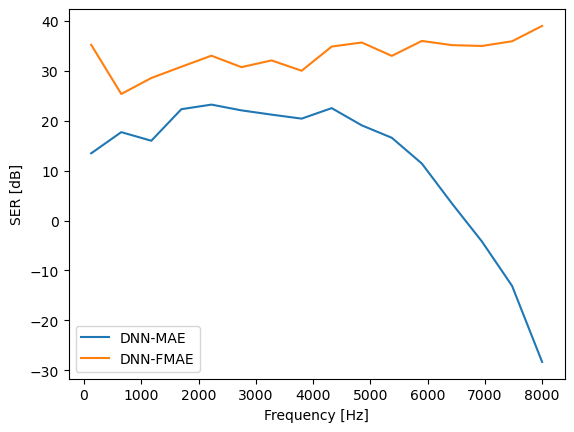

In [19]:
freq = np.linspace(125,8000,16)
SER_MAE = 10*np.log10(np.mean(out_ref**2,axis=1)/np.mean((out_ref-out_MAE)**2,axis=1))
SER_FMAE = 10*np.log10(np.mean(out_ref**2,axis=1)/np.mean((out_ref-out_FMAE)**2,axis=1))
plt.xlabel("Frequency [Hz]")
plt.ylabel("SER [dB]")
plt.plot(freq,SER_MAE)
plt.plot(freq,SER_FMAE)
plt.legend(["DNN-MAE", "DNN-FMAE"])